In [1]:
#circular inference model
import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
# import pystan
%matplotlib inline

In [2]:
def l_w(L,w):
    f = np.log((w*np.exp(L)+1-w) / ((1-w)*np.exp(L)+w))
    return f

In [3]:
def circular_inference(prior, left_like,right_like,param):

    pa1 = param[0]/2 +0.5
    pa2 = param[1]/2 +0.5
    pa3 = param[2]
    pa4 = param[3]

    #prior logit
    Cp = prior
    Fp = 1 - prior
    Lp = np.log(Cp/Fp)
    aplp = pa3*Lp
    Faplpwp = l_w(aplp,pa1)

    #likelihood logit
    Li_le = left_like
    Li_ri = right_like
    Ls = np.log(Li_le/Li_ri) 
    asls = pa4*Ls
    Faslsws = l_w(asls,pa2)

    Lc = l_w(Ls+Faplpwp+Faslsws,pa2) + l_w(Lp+Faslsws+Faplpwp,pa1)
    pred_c = np.exp(Lc)/(1+np.exp(Lc)) #+ np.random.uniform(low=-0.1, high=0.1)

    pred_c = np.clip(pred_c,0.018,0.982)
    

    return pred_c, Lc

In [4]:
data, image_data = preprocessing.preprocess()

In [ ]:
likelihood_dir = 'online_likelihood.csv'
like_data = pd.read_csv(likelihood_dir)

# print(like_data)
like_data['categ1_ave']
for i in range(1,101):
    data.loc[data['imgseq']==i,'correct_image'] = like_data.loc[like_data['im_number']==i,'categ1_ave'].values[0]
    data.loc[data['imgseq']==i,'false_image'] = like_data.loc[like_data['im_number']==i,'categ2_ave'].values[0]
    
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

/var/folders/cz/nzzq84dn7238znf9n03jnb780000gp/T/ipykernel_4335/1751405316.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('jet')


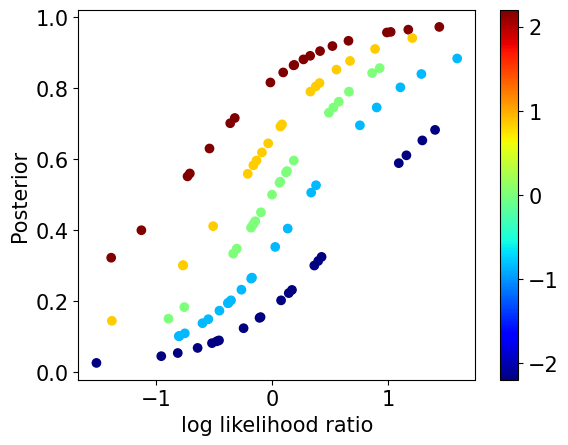

In [28]:
sub_list = []
# number_sub = 21
number_sub=1
sigma = 0
for subject_number in range(number_sub):
#     print(subject_number)
    sub_data = data[data['subject']==subject_number]
    prior_list = np.zeros(100)
    left_like_lis = np.zeros(100)
    right_like_lis = np.zeros(100)
    c_list = np.zeros(100)

    for trial in range(100):
        prior_list[trial] = sub_data.at[(100*subject_number)+trial,'prior']
        
        #likelihood depends on the corloc
        if sub_data.at[(100*subject_number)+trial,'corloc']==1:
            left_like_lis[trial] = sub_data.at[(100*subject_number)+trial,'correct_image']
            right_like_lis[trial] = sub_data.at[(100*subject_number)+trial,'false_image']
        elif sub_data.at[(100*subject_number)+trial,'corloc']==2:
            left_like_lis[trial] = sub_data.at[(100*subject_number)+trial,'false_image']
            right_like_lis[trial] = sub_data.at[(100*subject_number)+trial,'correct_image']

        c_list[trial] = sub_data.at[(100*subject_number)+trial,'posterior']

    prior_list = [n/100 for n in prior_list]
    left_like_lis = [n/100 for n in left_like_lis]
    right_like_lis = [n/100 for n in right_like_lis]
    c_list = [1 if c==0 else c for c in c_list]
    c_list = [99 if c==100 else c for c in c_list]
    c_list = [n/100 for n in c_list]

    wp = 0.8
    ws = 0.8
    alpha_p = 0
    alpha_s = 1
    
    params = [wp,ws,alpha_p,alpha_s]
    c_estimated = np.zeros(100)
    Lc = np.zeros(100)
    for t in range(100):
        c_estimated[t], Lc[t] = circular_inference(prior_list[t],left_like_lis[t],right_like_lis[t],params)
    
#     plt.plot(likelihood_list,c_estimated)

    prior_ratio = [np.log(prior/(1-prior)) for prior in prior_list]
    like_ratio = [np.log(left/right) for left, right in zip(left_like_lis,right_like_lis)]

    # cm = plt.cm.get_cmap('jet')
    # plt.scatter(prior_ratio,c_estimated,c=prior_ratio,cmap=cm)
    # plt.colorbar()
    # plt.xlabel('log Prior ratio')
    # plt.ylabel('Posterior')
    # plt.show()

    cm = plt.cm.get_cmap('jet')
    plt.scatter(like_ratio,c_estimated,c=prior_ratio,cmap=cm)
    plt.colorbar()
    plt.xlabel('log likelihood ratio')
    plt.ylabel('Posterior')
    plt.show()

/var/folders/cz/nzzq84dn7238znf9n03jnb780000gp/T/ipykernel_4335/3504682535.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('jet')


Text(0, 0.5, 'Posterior')

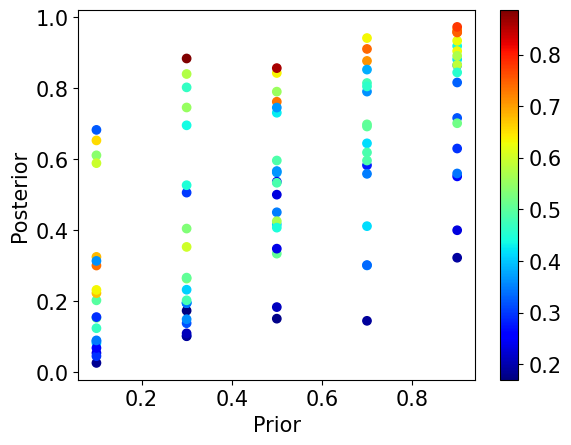

In [29]:
cm = plt.cm.get_cmap('jet')
plt.scatter(prior_list,c_estimated,c=left_like_lis,cmap=cm)
plt.colorbar()
plt.xlabel('Prior')
plt.ylabel('Posterior')